In [1]:
# 1. Get essential libraries
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Observations:  1640


<Axes: xlabel='Time'>

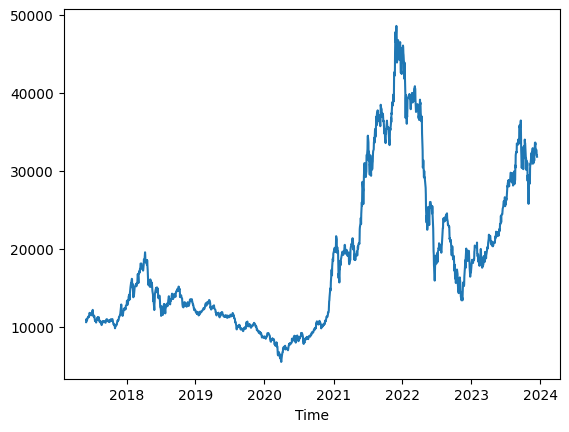

In [2]:
#2. Fetch data and visualize
# SSI
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
SSI["Close"].plot()

In [5]:
# Preprocessing
df = pd.DataFrame(SSI['Close'])
df = df.dropna() 
df = df.reset_index(drop=True)
df

,Close
0,10570
1,10950
2,10740
3,10870
4,10980
...,...
1635,32700
1636,32600
1637,32000
1638,32000


In [6]:
# Check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Close'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#Not stationary

ADF stat: -1.139246
p-value: 0.699170


In [7]:
adf2 = adfuller(df['Close'].diff().dropna(), regression ='c', maxlag=30)
print("ADF stat: %f" % adf2[0])
print("p-value: %f" % adf2[1])
#Stationary

ADF stat: -16.253531
p-value: 0.000000


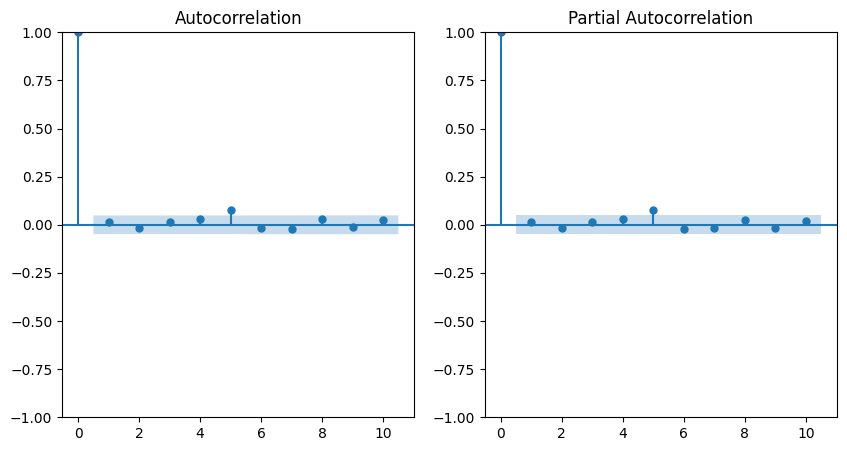

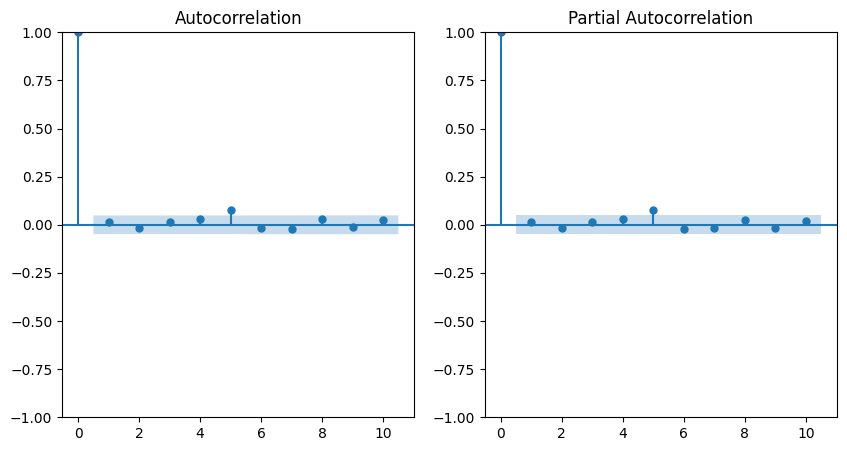

In [8]:
# Difference the data and plot the acf
fig, ax = plt.subplots(1,2,figsize=(10,5))
#ACF
sm.graphics.tsa.plot_acf(np.diff(df['Close']),lags=10, ax=ax[0])
# PACF
sm.graphics.tsa.plot_pacf(np.diff(df['Close']),lags=10, ax=ax[1])

In [9]:
# Test with ratio 6:4
train_size64 = int(0.6 * len(df))
test_size64 = int(0.4 * len(df))

train_data64 = df[:train_size64]
test_data64 = df[train_size64:]

In [10]:
# Test with ratio 6:4
x_train64 = np.array(train_data64.index).reshape(-1, 1)
y_train64 = np.array(train_data64['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

model64 = auto_arima(y_train64, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model_fit64 = model64.fit(y_train64)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14085.662, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14083.865, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14085.189, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14085.223, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14082.851, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14084.648, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.972 seconds


In [11]:
# 6:4 RATIO
x_test64 = np.array(test_data64.index).reshape(-1, 1)
y_test64 = np.array(test_data64['Close'])
y_pred64 = model64.predict(n_periods=len(y_test64))

In [12]:
# 6:4 RATIO
last_index64 =  df.index[-1]
last_data64 =pd.RangeIndex(start=last_index64, stop=last_index64 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days64 = np.array(range(last_index64 + 1, last_index64 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days64 = model64.predict(len(x_next_60_days64))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days64)

Predicted prices for the next 60 days: 
[20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280.
 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280.
 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280.
 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280.
 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280.
 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280. 20280.]


In [13]:
# 6:4 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred64 - y_test64)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test64 - y_pred64) / y_test64)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred64 - y_test64))
print('Testing MAE:', test_mae)

Testing RMSE: 11491.051119625283
Testing MAPE: 27.4193834395538
Testing MAE: 8918.727134146342


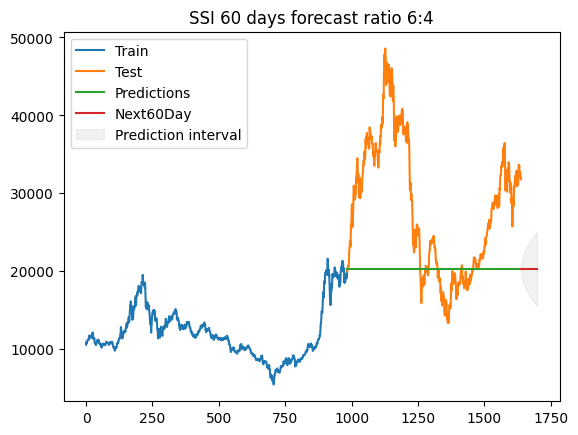

In [14]:
# 6:4 RATIO
# Forecast
n_periods = 60
fc, confint = model_fit64.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data64.index, train_data64['Close'])
plt.plot(test_data64.index, test_data64['Close'])
plt.plot(test_data64.index, y_pred64)

plt.plot(fc_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 6:4")
plt.show()
#The ratio and the model is not a good choice for this case

In [15]:
ARIMA(2,2,2)(0,0,0)[0] x            : AIC=inf, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0]   x          : AIC=13063.252, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]    x         : AIC=12847.718, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]     x        : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]      x       : AIC=12745.516, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=12671.990, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=12611.326, Time=0.06 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=12605.836, Time=0.06 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(5,2,0)(0,0,0)[0]

SyntaxError: invalid syntax (2813759551.py, line 1)

In [16]:
#Forecast with ARIMA(1, 1, 2)
model64 = sm.tsa.arima.ARIMA(
    train_data64,
    order = (1,1,1)
)
model_fit64 = model64.fit()
model_fit64.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  984
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7038.681
Date:                Sat, 30 Dec 2023   AIC                          14083.361
Time:                        22:14:10   BIC                          14098.033
Sample:                             0   HQIC                         14088.942
                                - 984                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8288      0.110      7.552      0.000       0.614       1.044
ma.L1         -0.7953      0.119     -6.675      0.000      -1.029      -0.562
sigma2       9.74e+04   2566.365     37.951      0.000    9.24e+04    1.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               663.23
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# 5. Testing process
# 8:2 RATIO
x_test64 = np.array(test_data64.index).reshape(-1, 1)
y_test64 = np.array(test_data64['Close'])
y_pred64 = model_fit64.predict(start = train_size64, end = train_size64+test_size64)
y_pred64

984     20314.782846
985     20343.609813
986     20367.500730
987     20387.300797
988     20403.710493
            ...     
1636    20483.134847
1637    20483.134847
1638    20483.134847
1639    20483.134847
1640    20483.134847
Name: predicted_mean, Length: 657, dtype: float64

In [18]:
# 6. 60 days prediction
# 8:2 RATIO
last_index64 =  df.index[-1]
last_data64 =pd.RangeIndex(start=last_index64, stop=last_index64 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days64 = np.array(range(last_index64 + 1, last_index64 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days64 = model_fit64.predict(start = len(df)+1, end = len(df)+60)
print(len(x_next_60_days64))
#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days64)

60
Predicted prices for the next 60 days: 
1641    20483.134847
1642    20483.134847
1643    20483.134847
1644    20483.134847
1645    20483.134847
1646    20483.134847
1647    20483.134847
1648    20483.134847
1649    20483.134847
1650    20483.134847
1651    20483.134847
1652    20483.134847
1653    20483.134847
1654    20483.134847
1655    20483.134847
1656    20483.134847
1657    20483.134847
1658    20483.134847
1659    20483.134847
1660    20483.134847
1661    20483.134847
1662    20483.134847
1663    20483.134847
1664    20483.134847
1665    20483.134847
1666    20483.134847
1667    20483.134847
1668    20483.134847
1669    20483.134847
1670    20483.134847
1671    20483.134847
1672    20483.134847
1673    20483.134847
1674    20483.134847
1675    20483.134847
1676    20483.134847
1677    20483.134847
1678    20483.134847
1679    20483.134847
1680    20483.134847
1681    20483.134847
1682    20483.134847
1683    20483.134847
1684    20483.134847
1685    20483.134847
1686    2048

In [24]:
# 6:4 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred64[:len(y_test64)] - y_test64)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test64 - y_pred64[:len(y_test64)]) / y_test64)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred64[:len(y_test64)] - y_test64))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred64[:len(y_test64)], y_test64))

Testing RMSE: 11353.932008597218
Testing MAPE: 27.198910378231915
Testing MAE: 8818.407857913488
Testing MSLR:  0.1670740386806303


ValueError: x and y must have same first dimension, but have shapes (656,) and (657,)

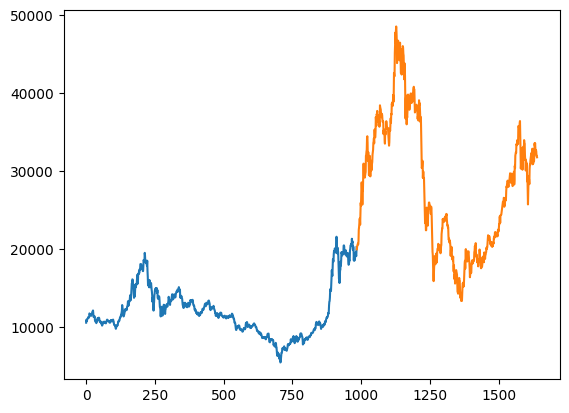

In [27]:
#Show plot ratio 6:4
plt.plot(train_data64.index, train_data64['Close'])
plt.plot(test_data64.index, test_data64['Close'])
plt.plot(test_data64.index, y_pred64)

plt.plot(last_data64,y_next_60_days64)
plt.legend(['Train', 'Test', 'Predictions','Next60Day'])
plt.show()
# Better